In [3]:
import warnings
warnings.filterwarnings('ignore')

# AutoEncoder(AE)
- 입력데이터의 차원축소를 통해 의미있는 잠재공간(Latent Space/Manifold)을 학습
  - Encoder 학습을 위해 Decoder를 사용

In [1]:
!nvidia-smi

Mon Mar 29 01:09:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
from keras.datasets import mnist
from keras import layers
from keras import models

In [29]:
import matplotlib.pyplot as plt

## 1. Load MNIST Dataset

In [5]:
(X_train, _) , (X_test, _) = mnist.load_data()
# y는 필요없으므로 받지 않음

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

### 1) Normailzation and Reshape

In [10]:
X_train = X_train / 255.
X_test = X_test / 255.

X_train = X_train.reshape(60000, 28 * 28)
X_test = X_test.reshape(10000, 28 * 28)

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

## 2. Keras Modeling with Functional API

### 1) 'Latent Space' Size

In [8]:
encoding_dim = 32
# 표현벡터의 크기 32개

### 2) Encoder
- input

In [11]:
input_img = layers.Input(shape = (784, ))

- Encoding Layers and Encoding Model

In [12]:
encoded = layers.Dense(256, activation = 'elu')(input_img)
encoded = layers.Dense(128, activation = 'elu')(encoded)
encoded = layers.Dense(encoding_dim, activation = 'elu')(encoded)

### 3) Decoder
- Decoding Layers and Decoding Model

In [13]:
decoded = layers.Dense(128, activation = 'elu')(encoded)
decoded = layers.Dense(256, activation = 'elu')(decoded)
decoded = layers.Dense(784, activation = 'sigmoid')(decoded)

## 3. AutoEncoder Model

### 1) 'autoencoder' Model

In [16]:
autoencoder = models.Model(input_img, decoded)
# autoencoder: 함께 학습. input_img를 넣어 decoded까지

In [17]:
autoencoder.summary()
# 784개로 들어가서 32개로 줄었다가 다시 784개가 됨
# 일반적으로 나비모양으로 만든다
# CNN도 사용 가능(DNN으로 latent space를 flatten해줘야 하고, decoder를 DECNN 처리 필요)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               201488

### 2) 'encoder' Model

In [18]:
encoder = models.Model(input_img, encoded)
# encoder: input에 encoded까지 붙여서 모델 생성

In [19]:
encoder.summary()
# 784를 받아서 32를 내보내고 끝남

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
Total params: 237,984
Trainable params: 237,984
Non-trainable params: 0
_________________________________________________________________


### 3) 'decoder' Model

In [21]:
encoded_input = layers.Input(shape = (encoding_dim, ))

decoder_layer = autoencoder.layers[-3](encoded_input)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)

# decoder: 32를 받아 784로 복구할 수 있도록

# 오토인코더에서 뒤에서부터 뽑아냄
# 인코더 + 디코더 파라미터 = 오토인코더 파라미터
# 실제 학습은 오토인코더에서 이루어짐

In [23]:
decoder = models.Model(encoded_input, decoder_layer)

In [24]:
decoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               201488    
Total params: 238,736
Trainable params: 238,736
Non-trainable params: 0
_________________________________________________________________


## 4. Model Fit

In [25]:
autoencoder.compile(loss = 'binary_crossentropy',
                    optimizer = 'adam')
# binary인 이유: input X가 output X인지 아닌지 비교

In [26]:
autoencoder.fit(X_train, X_train,
                epochs = 50,
                batch_size = 256,
                validation_data = (X_test, X_test))
# y가 없다

Epoch 1/50
235/235 [==============================] - 4s 5ms/step - loss: 0.1570 - val_loss: 0.0041
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0040 - val_loss: 0.0040

## 5. Model Predict

### 1) Image Encoding
- Create 'Latent Space'

In [27]:
encoded_imgs = encoder.predict(X_test)

encoded_imgs.shape
# X_test 를 집어넣으면 784가 32 차원으로 인코딩 됨 (latent space)

(10000, 32)

### 2) 'Latent Space' Decoding

In [28]:
decoded_imgs = decoder.predict(encoded_imgs)

decoded_imgs.shape
# 인코딩한 이미지를 디코더에 집어넣어 복원시키면, 784로 복원됨

(10000, 784)

## 6. Visualization
- 10개의 이미지 데이터를 모델에 적용

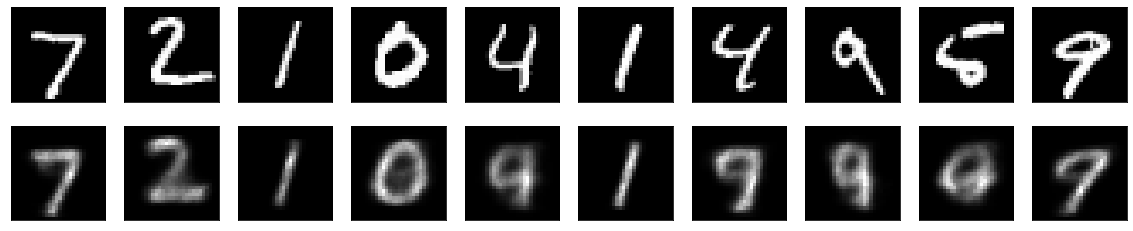

In [32]:
n = 10

plt.figure(figsize = (20, 4))

for i in range(n) :

  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
# 복원이 된 것을 볼 수 있다!
# 2개로 줄여도 생각보다 잘 동작함
# 레이어의 수를 줄이면 파라미터의 개수가 줄어들므로 성능이 떨어질 것